## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

In [15]:
def calibrate(images='camera_cal/calibration*.jpg'):

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(images)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    return objpoints, imgpoints

In [16]:
def undistort(objpoints, imgpoints, img):
    # Test undistortion on an image
    img_size = img.shape[0:2]

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return ret, mtx, dist, dst

## And so on and so forth...

In [17]:
objpoints, imgpoints = calibrate('/Users/Victor/Documents/Udacity-Selfdriving/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

In [18]:

def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [145]:

img = cv2.imread('/Users/Victor/Documents/Udacity-Selfdriving/CarND-Advanced-Lane-Lines/test_images/test1.jpg')
ret, mtx, dist, dst = undistort(objpoints, imgpoints, img)
undst = undistort_image(img, mtx, dist)


In [146]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [21]:
def sobelx(img, sobel_kernel = 3):
    return cv2.Sobel(img, cv2.CV_64F  ,1, 0)
def sobely(img, sobel_kernel = 3):
    return cv2.Sobel(img, cv2.CV_64F  ,0, 1)

In [28]:
def grad_x(img, thresh_min = 0, thresh_max = 255, sobel_kernel = 3):
    gray = grayscale(img)
    sobel_x = sobelx(gray, sobel_kernel)
    abs_sobelx = np.absolute(sobel_x)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary_output = np.zeros_like(scaled_sobelx)
    binary_output[(scaled_sobelx > thresh_min) & (scaled_sobelx < thresh_max)] = 1
    return binary_output
def grad_y(img, thresh_min = 0, thresh_max = 255, sobel_kernel = 3):
    gray = grayscale(img)
    sobel_y = sobely(gray, sobel_kernel)
    abs_sobely = np.absolute(sobel_y)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    binary_output = np.zeros_like(scaled_sobely)
    binary_output[(scaled_sobely > thresh_min) & (scaled_sobely < thresh_max)] = 1
    return binary_output

In [74]:
def grad_mag(img, mag_min = 0, mag_max = 255, sobel_kernel = 3):
    gray = grayscale(img)
    sobel_x = sobelx(gray, sobel_kernel)
    sobel_y = sobely(gray, sobel_kernel)
    abs_sobel = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    scaled_sobel = np.uint8(abs_sobel / np.max(abs_sobel) * 255)
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_min) & (scaled_sobel < mag_max)] = 1
    return binary_output
def grad_dir(img, dir_min = 0, dir_max = np.pi/2, sobel_kernel = 3):
    gray = grayscale(img)
    sobel_x = sobelx(gray, sobel_kernel)
    sobel_y = sobely(gray, sobel_kernel)
    abs_graddir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    scaled_sobel = np.uint8(abs_graddir / np.max(abs_graddir) * 255)
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > dir_min) & (scaled_sobel < dir_max)] = 1
    return binary_output
def HLS(img, s_min = 0, s_max = 255):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > s_min) & (S < s_max)] = 1
    return binary_output

In [130]:



def combined_threshold(img, sobel_kernel=3, grad_thresh=(30,100),mag_thresh=(80,100), dir_thresh=(0.8, 0.9),
                       s_thresh=(120,255)):
    sx_binary = grad_x(img, thresh_min = grad_thresh[0], thresh_max = grad_thresh[1])
    mag_binary = grad_mag(img, mag_min = mag_thresh[0], mag_max = mag_thresh[1])
    dir_binary = grad_dir(img, dir_min = dir_thresh[0], dir_max = dir_thresh[1])
    s_binary = HLS(img, s_min = s_thresh[0], s_max = s_thresh[1])
    combined = np.zeros_like(dir_binary)
    combined[(sx_binary == 1) | (mag_binary == 1)  | (dir_binary == 1) | (s_binary == 1) ] = 1
    return combined

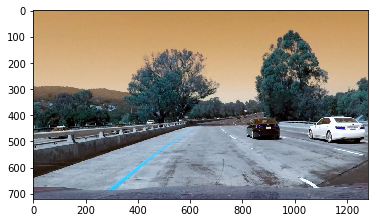

In [131]:
img = cv2.imread('/Users/Victor/Documents/Udacity-Selfdriving/CarND-Advanced-Lane-Lines/test_images/test1.jpg')
plt.imshow(img)

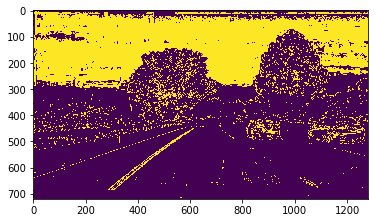

In [135]:
combined = combined_threshold(img)
plt.imshow(combined)

In [133]:
height, width = img.shape[0], img.shape[1]
vertice_bottom_left_y = height - 1
vertice_bottom_right_y = height - 1
vertice_top_left_x, vertice_top_left_y = (0.47 * width, 0.58 * height) 
vertice_top_right_x, vertice_top_right_y = (0.53 * width, 0.58 * height)
vertices = np.array([[(0,vertice_bottom_left_y),(width,vertice_bottom_right_y), (vertice_top_right_x,vertice_top_right_y), (vertice_top_left_x,vertice_top_left_y)]], dtype=np.int32)
    

In [140]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undst = cv2.undistort(img, mtx, dist)
    # 2) Convert to grayscale
    gray_undst = cv2.cvtColor(undst, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_undst, (9, 6), None)
    # 4) If corners found: 
    if ret == True:
            # a) draw corners
        img = cv2.drawChessboardCorners(undst, (9,6), corners, ret)
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        offset = 100 # offset for dst points

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        img_size = (gray_undst.shape[1], gray_undst.shape[0])

        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    #delete the next two lines
    M = cv2.getPerspectiveTransform(src, dst)    
    warped = cv2.warpPerspective(undst, M, img_size)    
    return warped, M

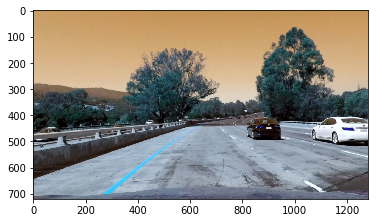

In [144]:
plt.imshow(undst)

In [152]:
chessboard = cv2.imread('/Users/Victor/Documents/Udacity-Selfdriving/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
ret, mtx, dist, dst = undistort(objpoints, imgpoints, chessboard)
top_down, perspective_M = corners_unwarp(chessboard, nx, ny, mtx, dist)


UnboundLocalError: local variable 'src' referenced before assignment

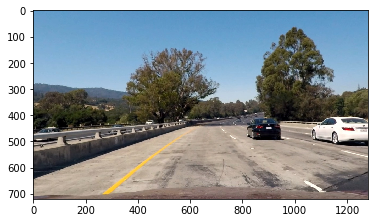

In [38]:
plt.imshow(undst)

In [29]:
def process_image(img):

    ret, mtx, dist, dst = undistort(objpoints, imgpoints, img)
    undst = undistort_image(img, mtx, dist)
    return img

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
project_output = '/Users/Victor/Documents/Udacity-Selfdriving/CarND-Advanced-Lane-Lines/project_output.mp4'
clip1 = VideoFileClip("/Users/Victor/Documents/Udacity-Selfdriving/CarND-Advanced-Lane-Lines/challenge_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video /Users/Victor/Documents/Udacity-Selfdriving/CarND-Advanced-Lane-Lines/project_output.mp4
[MoviePy] Writing video /Users/Victor/Documents/Udacity-Selfdriving/CarND-Advanced-Lane-Lines/project_output.mp4



100%|██████████| 485/485 [31:07<00:00,  3.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/Victor/Documents/Udacity-Selfdriving/CarND-Advanced-Lane-Lines/project_output.mp4 

CPU times: user 20min 36s, sys: 27 s, total: 21min 3s
Wall time: 31min 37s
